In [1]:
import pyspark

myConf=pyspark.SparkConf()

spark= pyspark.sql.SparkSession\
    .builder\
    .master('local')\
    .appName('myApp')\
    .config(conf=myConf)\
    .getOrCreate()

In [2]:
import os

_myDf= spark\
    .read\
    .format('com.databricks.spark.csv')\
    .options(header=True, inferschema=False, delimiter=',')\
    .load(os.path.join('data', '서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv'))
_myDf.show()

+----------+------+
|     �뿩��|�뿩�Ǽ�|
+----------+------+
|2018-01-01|  4950|
|2018-01-02|  7136|
|2018-01-03|  7156|
|2018-01-04|  7102|
|2018-01-05|  7705|
|2018-01-06|  5681|
|2018-01-07|  5220|
|2018-01-08|  6309|
|2018-01-09|  5988|
|2018-01-10|  4476|
|2018-01-11|  4337|
|2018-01-12|  4401|
|2018-01-13|  3756|
|2018-01-14|  4675|
|2018-01-15|  6993|
|2018-01-16|  7421|
|2018-01-17|  6990|
|2018-01-18|  7054|
|2018-01-19|  8329|
|2018-01-20|  6148|
+----------+------+
only showing top 20 rows



In [3]:
import pandas as pd
myDf_p=_myDf.toPandas()
myDf_p.columns=['date', 'count']
myDf=spark.createDataFrame(myDf_p)
# _myDf.printSchema()

spark dataframe 상태로는 깨진 column명을 수정할 수 없어, 
pandas dataframe으로 변환하여 column명을 전체 수정한 뒤, 다시 대용량처리에 적합한 spark dataframe으로 변환하였습니다.

In [4]:
myDf.show()

+----------+-----+
|      date|count|
+----------+-----+
|2018-01-01| 4950|
|2018-01-02| 7136|
|2018-01-03| 7156|
|2018-01-04| 7102|
|2018-01-05| 7705|
|2018-01-06| 5681|
|2018-01-07| 5220|
|2018-01-08| 6309|
|2018-01-09| 5988|
|2018-01-10| 4476|
|2018-01-11| 4337|
|2018-01-12| 4401|
|2018-01-13| 3756|
|2018-01-14| 4675|
|2018-01-15| 6993|
|2018-01-16| 7421|
|2018-01-17| 6990|
|2018-01-18| 7054|
|2018-01-19| 8329|
|2018-01-20| 6148|
+----------+-----+
only showing top 20 rows



In [5]:
from pyspark.sql.functions import when
from pyspark.sql.functions import *

# df= myDf.withColumn('year', (when(myDf.date.startswith('2019'), '2019').otherwise('2018')))
df= myDf.withColumn('year', year(to_timestamp('date','yyyy-MM-dd')))\
    .withColumn('month', month(to_timestamp('date', 'yyyy-MM-dd')))
df.show()

+----------+-----+----+-----+
|      date|count|year|month|
+----------+-----+----+-----+
|2018-01-01| 4950|2018|    1|
|2018-01-02| 7136|2018|    1|
|2018-01-03| 7156|2018|    1|
|2018-01-04| 7102|2018|    1|
|2018-01-05| 7705|2018|    1|
|2018-01-06| 5681|2018|    1|
|2018-01-07| 5220|2018|    1|
|2018-01-08| 6309|2018|    1|
|2018-01-09| 5988|2018|    1|
|2018-01-10| 4476|2018|    1|
|2018-01-11| 4337|2018|    1|
|2018-01-12| 4401|2018|    1|
|2018-01-13| 3756|2018|    1|
|2018-01-14| 4675|2018|    1|
|2018-01-15| 6993|2018|    1|
|2018-01-16| 7421|2018|    1|
|2018-01-17| 6990|2018|    1|
|2018-01-18| 7054|2018|    1|
|2018-01-19| 8329|2018|    1|
|2018-01-20| 6148|2018|    1|
+----------+-----+----+-----+
only showing top 20 rows



### 문제 1-1: 년도별 대여건수 합계

In [6]:
dy= df.groupBy('year').agg({'count':'sum'})
dy= dy.withColumn('sum(count)', col('sum(count)').cast('integer'))
dy.show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 문제 1-2: 년도별, 월별 대여건수 합계

In [7]:
dym= df.groupBy('year').pivot('month').agg({'count':'sum'})
dym.show()

+----+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+--------+--------+
|year|       1|       2|       3|       4|       5|        6|        7|        8|        9|       10|      11|      12|
+----+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+--------+--------+
|2018|164367.0|168741.0|462661.0|687885.0|965609.0|1207123.0|1100015.0|1037505.0|1447993.0|1420621.0|961532.0|500822.0|
|2019|495573.0|471543.0|904819.0|    null|    null|     null|     null|     null|     null|     null|    null|    null|
+----+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+--------+--------+



### 문제 1-3: 년도별, 월별 대여건수 그래프

In [8]:
import matplotlib.pyplot as plt
import numpy as np

month_list= list(range(1,13))

data= dym.rdd.map(lambda _data: _data[1:]).collect()
data18= np.array(data)[0]
data19= np.array(data)[1]

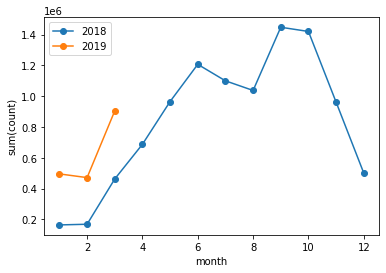

In [9]:
plt.plot(month_list, data18, marker='o')
plt.plot(month_list, data19, marker='o')
plt.xlabel('month')
plt.ylabel('sum(count)')
plt.legend(['2018', '2019'])
plt.show()